In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sdes.sdes import SDE
from sdes.tools import plot_simulations, struct_array_to_array, univariate_simulation_test

Some functions that are used to create plots are written here:

In [2]:
def plot_simulations(X, t_start = 0., t_end = 1.):
    fig, ax = plt.subplots()
    t_s = np.array([[float(name) for name in X.dtype.names]])
    data = np.stack([X[name] for name in X.dtype.names])
    ax.plot(t_s.T, data)
    return fig, ax

def struct_array_to_array(A):
    return np.array([A[name][0] for name in A.dtype.names])

def univariate_simulation_test(sde, nums, dist_kwargs):
    fig, ax = plt.subplots()
    for num in nums:
        dist_kwargs['num'] = num
        rvs = sde.simulate(size=1, **dist_kwargs)
        t_s = [dist_kwargs['t_start']] + [float(t) for t in rvs.dtype.names]
        X_ts = struct_array_to_array(rvs); X_ts = np.concatenate([np.array([dist_kwargs['x_start']]), X_ts])
        ax.plot(t_s, X_ts, label=f'n_points = {num}')
    # Configure axis settings
    ax.legend(); ax.set_xlabel('t'); ax.set_ylabel('X_t'); ax.grid(visible=True)
    return fig, ax

# Defining and simulating from SDEs

In this notebook, we test and demonstrate how to construct and generate distributions and simulations from your own SDE objects. We only consider the univariate case only.

## Univariate SDEs

One can construct a univariate SDE by constructing a subclass of `SDE`. We work with the univariate Ornstein-Uhlenbeck process as a motivating example, which is defined by the following SDE:

$$dX_t = \theta_1(\mu - X_t)dt + \theta_2 dW_t$$

The parameters of the SDE are given by $\theta = (\theta_1, \theta_2, \mu)$.

In [3]:
class OrnsteinUhlenbeck(SDE):
    default_params = {'theta_1': 1.0,  
                      'mu': 1.0, 
                      'theta_2': 1.0}

    def b(self, t, x):
        return self.theta_1*(self.mu - x)

    def sigma(self, t, x):
        return self.theta_2

Once the SDE has been created, an instance of the SDE can then be construted by instantiating the constructed class, with any specific choice for the parameter $\theta$:

In [4]:
param_vals = {'theta_1': 1.0,  
              'mu': 1.0, 
              'theta_2': 0.2}
ou_sde = OrnsteinUhlenbeck(**param_vals)

The user accessible methods of the SDE class are `simulate` and `distribution`. The distribution method can be used as follows:  

In [5]:
ou_x_start = np.array([0., 0., 0., 1., 1., 1., 2., 2., 2.])
dist_kwargs = {'t_start': 0.0,
               't_end': 1.0,
               'x_start': ou_x_start,
               'num': 1000}

ou_distn = ou_sde.distribution(**dist_kwargs)

The `ou_distn` object that has been created in the code above, is an instance of the  `ProbDist` class as defined in the `particles` package. These `ProbDist` objects represent distributions, and are used as the building block when constructing state space models. The distribution has been constructed as a product of Euler-Maruyama transition densities to approximate the true joint density of the points on the SDE.

One can generate random variables with this distribution, either by calling the `rvs` method on the constructed `ProbDist`, or equivalently by calling the method `simulate` on the SDE:

In [6]:
N = 9
# These 2 lines are equivalent
rvs_1 = ou_distn.rvs(size=N)
rvs_2 = ou_sde.simulate(size=N, **dist_kwargs)

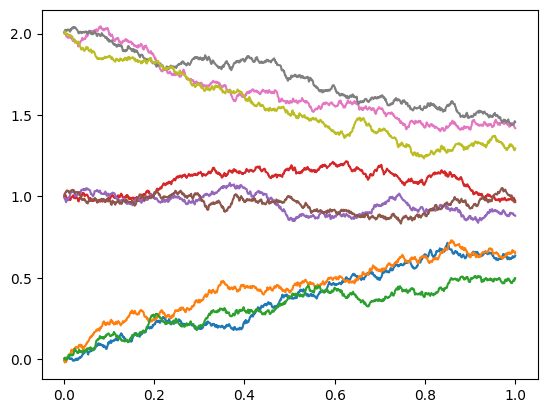

In [7]:
plot_simulations(rvs_1);

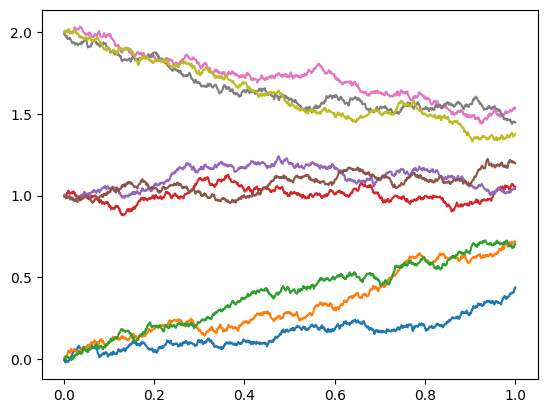

In [8]:
plot_simulations(rvs_2);

For any given SDE, one can also use the `transform_X_to_W` methods on simulations, to recover the driving noise of each simulation:

In [9]:
transform_kwargs = {'t_start': 0.0,
                 'x_start': ou_x_start}
driving_noise = ou_sde.transform_X_to_W(rvs_1, **transform_kwargs)

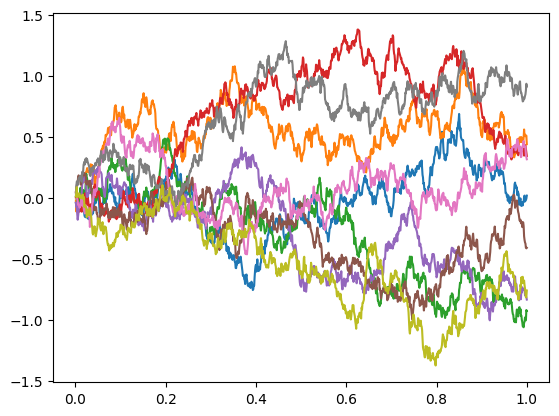

In [10]:
plot_simulations(driving_noise)
plt.show()

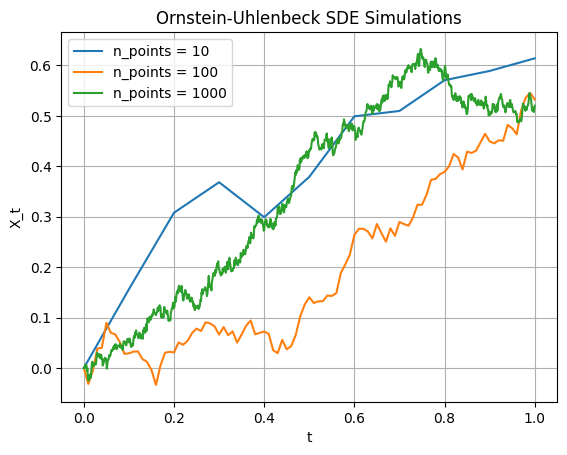

In [11]:
nums = [10, 100, 1000]
dist_kwargs['x_start'] = 0.
fig, ax = univariate_simulation_test(ou_sde, nums, dist_kwargs)
ax.set_title('Ornstein-Uhlenbeck SDE Simulations')
plt.show()

### Brownian Bridge SDE

We also test the implementation for a time-inhomogeneous case, by considering the Brownian Bridge SDE:

$$dX_t = \frac{x^* - X_t}{1-t}dt + dW_t$$

We assume that $X_0 = x_0$.
The parameter of the SDE is the fixed end point: $x^*$. One can solve this SDE analytically to obtain:

$$X_t = x_0(1-t) + x^*t + (1-t)\int_0^t \frac{dW_s}{1-s}$$

We define the Brownian Bridge SDE below:

In [12]:
class BrownianBridge(SDE):
    default_params = {'x_star': 0.}
    
    def b(self, t, x):
        return (self.x_star - x)/(1-t)
    
    def sigma(self, t, x):
        return 1.

We then create an instance of this SDE:

In [13]:
end_point = 1.0
bb_sde = BrownianBridge(x_star = end_point)

We can simulate from this SDE:

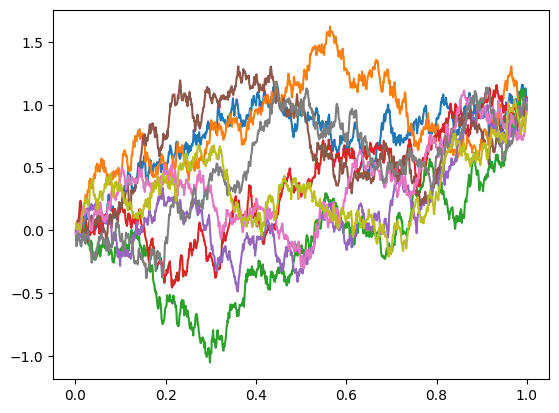

In [14]:
bb_sims = bb_sde.simulate(size=N, **dist_kwargs)
plot_simulations(bb_sims);

And we can invert the simulations to recover the original driving noise:

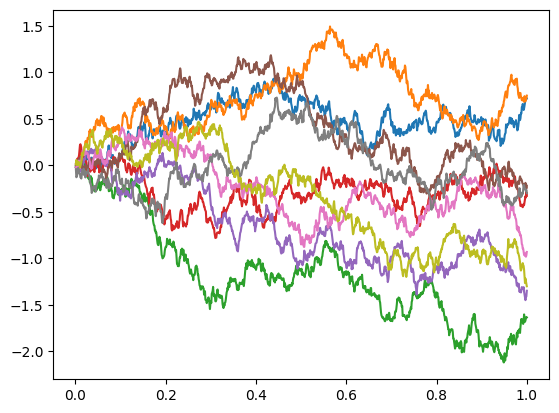

In [15]:
bb_driving_noise = bb_sde.transform_X_to_W(bb_sims)
plot_simulations(bb_driving_noise);

If we inverted the OU simulations using the inversion function of the Brownian Bridge, we would not recover sample paths of Brownian motions:

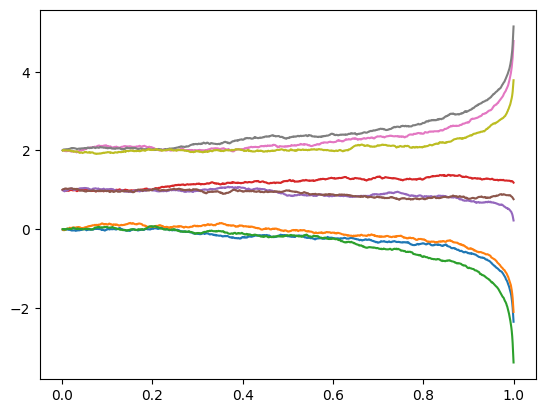

In [16]:
bb_inverted_ou = bb_sde.transform_X_to_W(rvs_1)
plot_simulations(bb_inverted_ou);

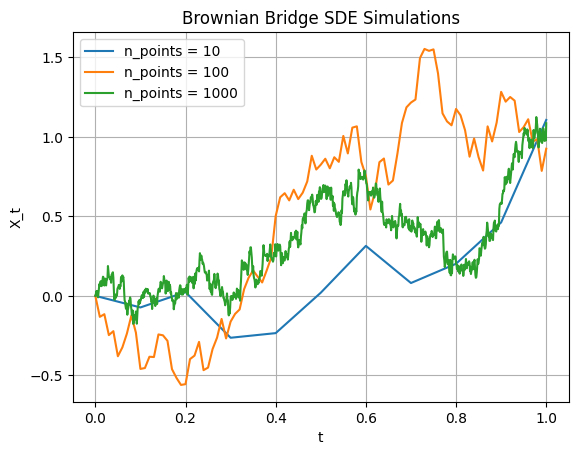

In [17]:
dist_kwargs = {'t_start': 0.0,
               't_end': 1.0,
               'x_start': 0.0,
               }
nums = [10, 100, 1000]

fig, ax = univariate_simulation_test(bb_sde, nums, dist_kwargs)
ax.set_title('Brownian Bridge SDE Simulations')
plt.show()

The Brownian Bridge starts at $X_0 = x_0$ and ends at $X_1 = x^*$ with probability 1. Due to the numerical scheme that is used to approximate the solution to the SDE, the simulations will not necessarily hit the end point $x^*$.